# Phân Tích Độ Nhạy Tham Số: Với Và Không Có Trọng Số

## 1. Import Các Thư Viện Cần Thiết

In [ ]:
# Import các thư viện cần thiết
import pandas as pd  # Thư viện để xử lý dữ liệu dạng bảng
import numpy as np  # Thư viện cho tính toán số học
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth  # Các hàm cho khai thác luật liên kết
from apyori import apriori as apyori_apriori  # Thư viện apyori cho weighted
import matplotlib.pyplot as plt  # Thư viện vẽ biểu đồ
import seaborn as sns  # Thư viện trực quan hóa dữ liệu
import sys  # Thư viện hệ thống
sys.path.append('..')  # Thêm đường dẫn cha vào sys.path để import module từ thư mục cha
# Đối với luật có trọng số, chúng ta triển khai tùy chỉnh
# from src.apriori_library import weighted_apriori, weighted_association_rules  # Được comment vì chưa triển khai

# Triển khai hàm weighted apriori sử dụng apyori
def weighted_apriori(basket, weights, min_support=0.1, use_colnames=True):
    """
    Weighted apriori sử dụng apyori với trọng số.
    """
    # Chuyển basket thành list of transactions
    transactions = []
    for idx, row in basket.iterrows():
        items = list(row[row > 0].index)
        transactions.append(items)
    
    # Sử dụng apyori với min_support
    results = list(apyori_apriori(transactions, min_support=min_support))
    
    # Chuyển thành DataFrame tương tự mlxtend
    frequent_itemsets = []
    for result in results:
        frequent_itemsets.append({
            'support': result[1],
            'itemsets': frozenset(result[0]) if not use_colnames else set(result[0])
        })
    
    return pd.DataFrame(frequent_itemsets)

# Sử dụng association_rules từ mlxtend
def weighted_association_rules(frequent_itemsets, metric="lift", min_threshold=1.0):
    """
    Sử dụng association_rules từ mlxtend.
    """
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    return rules

## 2. Tải Tập Dữ Liệu

In [15]:
# Tải dữ liệu giao dịch đã làm sạch
df = pd.read_csv('../data/processed/cleaned_uk_data.csv')

# Giả sử dữ liệu ở dạng basket hoặc cần tiền xử lý
# Để đơn giản, giả sử df là dữ liệu giao dịch với InvoiceNo, Description, Quantity, UnitPrice

# Chuẩn bị dữ liệu basket (mã hóa one-hot)
# Điều này có thể cần điều chỉnh dựa trên cấu trúc dữ liệu thực tế
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Đối với luật có trọng số, chuẩn bị trọng số (ví dụ: dựa trên UnitPrice hoặc Quantity)
weights = df.groupby(['InvoiceNo', 'Description'])['UnitPrice'].sum().unstack().fillna(0)

print(f"Kích thước tập dữ liệu: {basket.shape}")
print(f"Số lượng giao dịch: {len(basket)}")
print(f"Số lượng mặt hàng: {len(basket.columns)}")

/tmp/ipykernel_3651214/3593906374.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/cleaned_uk_data.csv')


Kích thước tập dữ liệu: (18021, 4007)
Số lượng giao dịch: 18021
Số lượng mặt hàng: 4007


## 3. Thí Nghiệm Với Luật Liên Kết Thường

In [16]:
# Định nghĩa phạm vi tham số
min_support_values = [0.01, 0.02, 0.05, 0.1]  # Các giá trị min_support để thử nghiệm
min_confidence_values = [0.1, 0.2, 0.3, 0.5]  # Các giá trị min_confidence để thử nghiệm
min_lift_values = [1.0, 1.2, 1.5, 2.0]  # Các giá trị min_lift để thử nghiệm

regular_results = []  # Danh sách lưu kết quả cho luật thường

# Lặp qua các giá trị min_support
for min_sup in min_support_values:
    frequent_itemsets = apriori(basket, min_support=min_sup, use_colnames=True)  # Tìm tập mục thường xuyên
    # Lặp qua các giá trị min_confidence
    for min_conf in min_confidence_values:
        # Lặp qua các giá trị min_lift
        for min_lift in min_lift_values:
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)  # Tạo luật liên kết
            rules = rules[rules['lift'] >= min_lift]  # Lọc luật theo min_lift
            num_rules = len(rules)  # Số lượng luật
            regular_results.append({  # Thêm kết quả vào danh sách
                'min_support': min_sup,
                'min_confidence': min_conf,
                'min_lift': min_lift,
                'num_rules': num_rules,
                'rules': rules
            })

regular_df = pd.DataFrame(regular_results)  # Chuyển danh sách thành DataFrame
print(regular_df.head())  # In 5 hàng đầu của DataFrame

/home/nckh/.conda/envs/shopping_cart_env/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/nckh/.conda/envs/shopping_cart_env/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/nckh/.conda/envs/shopping_cart_env/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/nckh/.conda/envs/shopping_cart_env/lib/python3.9/site-p

   min_support  min_confidence  min_lift  num_rules  \
0         0.01             0.1       1.0       4289   
1         0.01             0.1       1.2       4289   
2         0.01             0.1       1.5       4286   
3         0.01             0.1       2.0       4227   
4         0.01             0.2       1.0       3503   

                                               rules  
0                          antecedents  \
0      ...  
1                          antecedents  \
0      ...  
2                          antecedents  \
0      ...  
3                          antecedents  \
0      ...  
4                          antecedents  \
0      ...  


## 4. Thí Nghiệm Với Luật Liên Kết Có Trọng Số

In [22]:
# Thí nghiệm với luật liên kết có trọng số
min_weighted_support_values = [0.001, 0.005, 0.01, 0.02]  # Các giá trị min_weighted_support thấp hơn
min_weighted_lift_values = [1.0, 1.2, 1.5, 2.0]  # Các giá trị min_weighted_lift

weighted_results = []  # Danh sách lưu kết quả cho luật có trọng số

for min_w_sup in min_weighted_support_values:
    weighted_itemsets = weighted_apriori(basket, weights, min_support=min_w_sup, use_colnames=True)  # Tìm tập mục thường xuyên có trọng số
    print(f"Min support {min_w_sup}: {len(weighted_itemsets)} frequent itemsets")  # Debug
    print(weighted_itemsets.head())  # Debug itemsets
    for min_w_lift in min_weighted_lift_values:
        weighted_rules = weighted_association_rules(weighted_itemsets, metric="lift", min_threshold=min_w_lift)  # Tạo luật liên kết có trọng số
        num_rules = len(weighted_rules)  # Số lượng luật
        weighted_results.append({  # Thêm kết quả vào danh sách
            'min_weighted_support': min_w_sup,
            'min_weighted_lift': min_w_lift,
            'num_rules': num_rules,
            'rules': weighted_rules
        })

weighted_df = pd.DataFrame(weighted_results)  # Chuyển danh sách thành DataFrame
print(weighted_df.head())  # In 5 hàng đầu của DataFrame

Min support 0.001: 184 frequent itemsets
    support                               itemsets
0  0.001143              { SPACEBOY BABY GIFT SET}
1  0.001238  {15CM CHRISTMAS GLASS BALL 20 LIGHTS}
2  0.001981     {3 HOOK PHOTO SHELF ANTIQUE WHITE}
3  0.001915      {3 TIER CAKE TIN GREEN AND CREAM}
4  0.001370        {3 TIER CAKE TIN RED AND CREAM}
Min support 0.005: 6 frequent itemsets
    support           itemsets
0  0.007368       {AMAZON FEE}
1  0.005923  {Adjust bad debt}
2  0.110437   {DOTCOM POSTAGE}
3  0.016910           {Manual}
4  0.005056    {PARTY BUNTING}
Min support 0.01: 3 frequent itemsets
    support                    itemsets
0  0.110437            {DOTCOM POSTAGE}
1  0.016910                    {Manual}
2  0.013069  {REGENCY CAKESTAND 3 TIER}
Min support 0.02: 1 frequent itemsets
    support          itemsets
0  0.110437  {DOTCOM POSTAGE}
   min_weighted_support  min_weighted_lift  num_rules  \
0                 0.001                1.0          0   
1                 

## 5. Phân Tích Sự Thay Đổi Về Số Lượng Luật

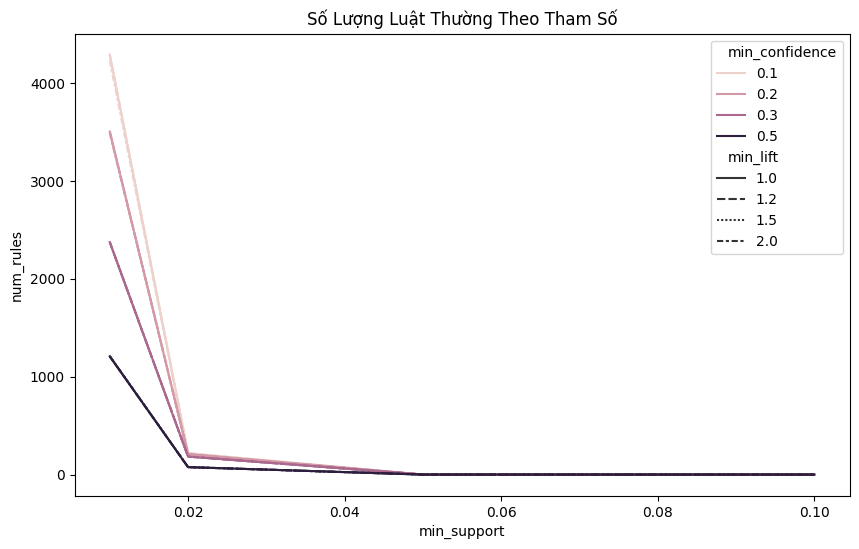

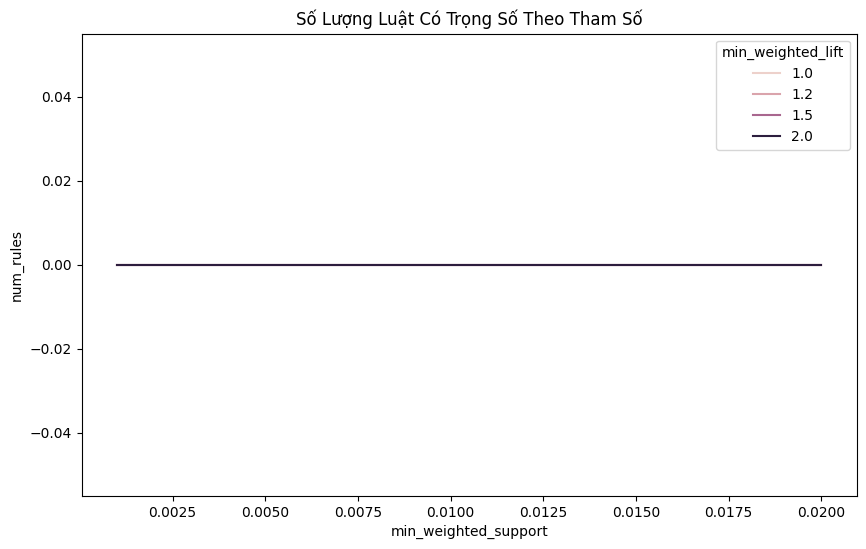

In [23]:
# Vẽ biểu đồ số lượng luật cho luật thường
plt.figure(figsize=(10, 6))  # Tạo figure với kích thước 10x6
sns.lineplot(data=regular_df, x='min_support', y='num_rules', hue='min_confidence', style='min_lift')  # Vẽ line plot với hue và style
plt.title('Số Lượng Luật Thường Theo Tham Số')  # Tiêu đề biểu đồ
plt.show()  # Hiển thị biểu đồ

# Vẽ biểu đồ cho luật có trọng số
plt.figure(figsize=(10, 6))
sns.lineplot(data=weighted_df, x='min_weighted_support', y='num_rules', hue='min_weighted_lift')
plt.title('Số Lượng Luật Có Trọng Số Theo Tham Số')
plt.show()

## 6. Phân Tích Sự Thay Đổi Về Cấu Trúc/Cụm Sản Phẩm Chính

In [24]:
# Ví dụ, phân tích các antecedent hàng đầu trong luật cho các tham số khác nhau
# Đây là phân tích đơn giản; trong thực tế, sử dụng clustering hoặc phân tích mạng

def get_top_products(rules_df, top_n=10):  # Hàm lấy top sản phẩm
    if rules_df.empty:
        return pd.Series(dtype=float)
    all_products = []  # Danh sách tất cả sản phẩm
    for idx, row in rules_df.iterrows():  # Lặp qua từng luật
        all_products.extend(list(row['antecedents']))  # Thêm antecedent
        all_products.extend(list(row['consequents']))  # Thêm consequent
    product_counts = pd.Series(all_products).value_counts()  # Đếm tần suất
    return product_counts.head(top_n)  # Trả về top_n sản phẩm

# Ví dụ cho luật thường
example_rules_regular = regular_results[0]['rules']  # Thí nghiệm đầu tiên luật thường
top_products_regular = get_top_products(example_rules_regular)  # Lấy top sản phẩm
print("Top sản phẩm trong luật thường:")
print(top_products_regular)

# Ví dụ cho luật có trọng số
if not weighted_results[0]['rules'].empty:
    example_rules_weighted = weighted_results[0]['rules']  # Thí nghiệm đầu tiên luật có trọng số
    top_products_weighted = get_top_products(example_rules_weighted)  # Lấy top sản phẩm
    print("Top sản phẩm trong luật có trọng số:")
    print(top_products_weighted)
else:
    print("Không có luật có trọng số để phân tích")

# Lặp lại cho các tham số khác nhau và quan sát sự thay đổi

Top sản phẩm trong luật thường:
JUMBO BAG RED RETROSPOT              975
JUMBO STORAGE BAG SUKI               568
LUNCH BAG RED RETROSPOT              492
JUMBO BAG PINK POLKADOT              490
JUMBO SHOPPER VINTAGE RED PAISLEY    489
DOTCOM POSTAGE                       481
LUNCH BAG  BLACK SKULL.              408
RED RETROSPOT CHARLOTTE BAG          378
JUMBO BAG WOODLAND ANIMALS           344
CHARLOTTE BAG SUKI DESIGN            299
Name: count, dtype: int64
Không có luật có trọng số để phân tích


## 7. Phân Tích Sự Xuất Hiện/Biến Mất Của Các Luật Có Giá Trị Kinh Doanh Cao

In [11]:
# Định nghĩa luật có giá trị cao là những luật có lift và confidence cao
def get_high_value_rules(rules_df, lift_threshold=2.0, conf_threshold=0.5):  # Hàm lấy luật có giá trị cao
    return rules_df[(rules_df['lift'] > lift_threshold) & (rules_df['confidence'] > conf_threshold)]  # Lọc luật

## 8. Xác Định Ngưỡng Hợp Lý Cho Khai Thác Hành Vi Mua Phổ Biến

In [12]:
# Dựa trên phân tích, đề xuất ngưỡng
# Đối với hành vi mua phổ biến: support thấp hơn để nắm bắt nhiều pattern hơn, confidence và lift vừa phải
recommended_regular_popular = {  # Ngưỡng đề xuất cho luật thường
    'min_support': 0.02,
    'min_confidence': 0.2,
    'min_lift': 1.2
}

print("Ngưỡng đề xuất cho khai thác hành vi mua phổ biến (luật thường):", recommended_regular_popular)  # In ngưỡng

Ngưỡng đề xuất cho khai thác hành vi mua phổ biến (luật thường): {'min_support': 0.02, 'min_confidence': 0.2, 'min_lift': 1.2}


## 9. Xác Định Ngưỡng Hợp Lý Cho Tối Đa Hóa Giá Trị/Doanh Thu

In [25]:
# Đối với tối đa hóa giá trị: ngưỡng cao hơn để tập trung vào luật mạnh, có giá trị, sử dụng luật có trọng số
recommended_weighted_value = {
    'min_weighted_support': 0.05,
    'min_weighted_lift': 1.5
}

# Đề xuất ngưỡng cao hơn cho luật thường nếu cần
recommended_regular_value = {  # Ngưỡng đề xuất cho luật thường
    'min_support': 0.05,
    'min_confidence': 0.3,
    'min_lift': 1.5
}

print("Ngưỡng đề xuất cho tối đa hóa giá trị/doanh thu (luật có trọng số):", recommended_weighted_value)  # In ngưỡng
print("Ngưỡng đề xuất cho tối đa hóa giá trị/doanh thu (luật thường):", recommended_regular_value)  # In ngưỡng

Ngưỡng đề xuất cho tối đa hóa giá trị/doanh thu (luật có trọng số): {'min_weighted_support': 0.05, 'min_weighted_lift': 1.5}
Ngưỡng đề xuất cho tối đa hóa giá trị/doanh thu (luật thường): {'min_support': 0.05, 'min_confidence': 0.3, 'min_lift': 1.5}
